<a href="https://colab.research.google.com/github/anasharma7/CYBERSEC/blob/main/ProjectML3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset (replace with your actual file path/name if different)
try:
    df = pd.read_csv('wc1.csv')
except FileNotFoundError:
    print("Please upload 'wc1.csv' to Colab or check the file path.")

# --- Preprocessing Steps (as done in your previous work) ---
# Separate features (X) and target (y)
X = df.drop('type', axis=1) # type is the target column [cite: 645]
y = df['type']              # Target column [cite: 646]

# Encode the target variable 'type' (alexa/phish to 0/1)
le = LabelEncoder()
y_encoded = le.fit_transform(y) # phish is encoded as 1 [cite: 649, 653]

# Scale the features (Normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X_scaled is the normalized feature matrix [cite: 661, 662]

# Split data into training and testing sets (using the ~67/33 split from your notebook)
# You used test_size=8.33% which results in Train/Test: 16235/7997 (33% test is 0.33)
# To match your previous split (which was ~33% test), we use 0.33
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.33, random_state=42, stratify=y_encoded
)

# --- Model Definitions (Matching the best performing versions) ---
# LR: Default solver='lbfgs' is fine for scaled data
lr_model = LogisticRegression(random_state=42)

# RF: Using the best n_estimators=500 found in your analysis [cite: 234]
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)

# NN: Using the converged max_iter=500 found in your analysis [cite: 350, 351]
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Train all models on the scaled training data
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)

models = {
    'Logistic Regression (LR)': lr_model,
    'Random Forest (RF)': rf_model,
    'Neural Network (NN)': nn_model
}

--- Q1: ROC AUC Scores ---
Logistic Regression (LR): AUC = 0.8420
Random Forest (RF): AUC = 0.9511
Neural Network (NN): AUC = 0.9101


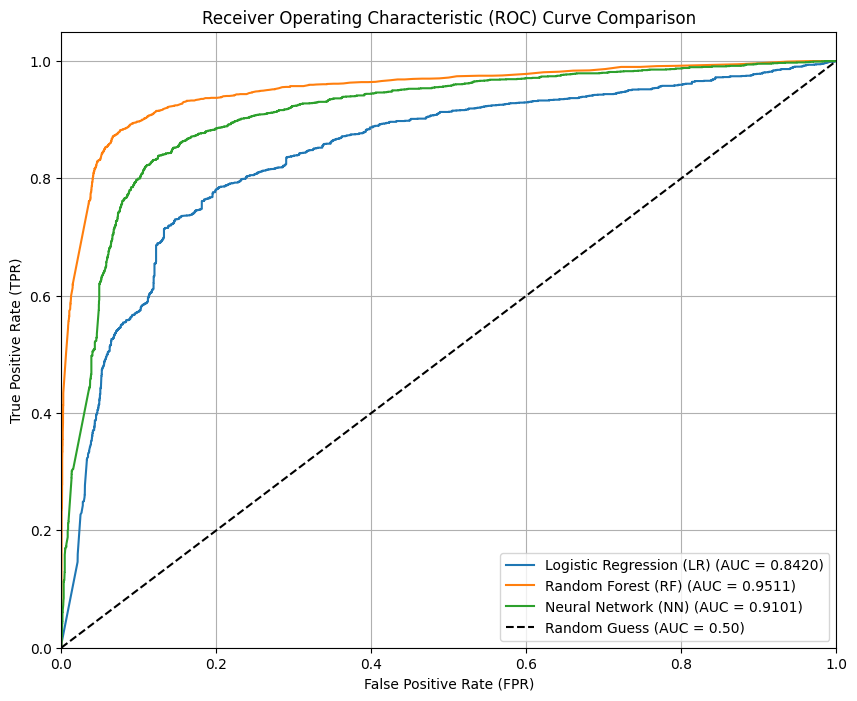


Conclusion for Q1: The Random Forest (RF) algorithm gives the best result with an AUC of 0.9511[cite: 474].


In [2]:
# --- 1. Draw ROC Curves and Compare AUC ---
plt.figure(figsize=(10, 8))
best_auc = 0
best_model_name = ""

print("--- Q1: ROC AUC Scores ---")

for name, model in models.items():
    # Predict probabilities for the positive class (phish=1)
    y_score = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve metrics
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

    print(f"{name}: AUC = {roc_auc:.4f}")

    # Track the best model
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model_name = name

# Final plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nConclusion for Q1: The {best_model_name} algorithm gives the best result with an AUC of {best_auc:.4f}[cite: 474].")

In [3]:
# --- 2. Apply 10-Fold Cross-Validation (CV) ---
print("\n--- Q2: 10-Fold Cross-Validation (Accuracy) ---")
cv_accuracies = {}
best_cv_score = 0
best_cv_model = ""

for name, model in models.items():
    # Use the entire scaled dataset (X_scaled, y_encoded) for 10-fold CV
    # n_jobs=-1 uses all available processors for faster computation
    scores = cross_val_score(model, X_scaled, y_encoded, cv=10, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    std_dev = scores.std() * 2 # 2*standard deviation is often used to show confidence interval

    cv_accuracies[name] = mean_score

    print(f"Algorithm: {name}")
    print(f"  Mean CV Accuracy: {mean_score:.4f} (+/- {std_dev:.4f})")

    # Track the best model
    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_cv_model = name

print(f"\nConclusion for Q2: The {best_cv_model} algorithm leads to the best performance with a mean 10-fold CV accuracy of {best_cv_score:.4f}.")


--- Q2: 10-Fold Cross-Validation (Accuracy) ---
Algorithm: Logistic Regression (LR)
  Mean CV Accuracy: 0.8256 (+/- 0.0115)
Algorithm: Random Forest (RF)
  Mean CV Accuracy: 0.9269 (+/- 0.0113)
Algorithm: Neural Network (NN)
  Mean CV Accuracy: 0.8746 (+/- 0.0134)

Conclusion for Q2: The Random Forest (RF) algorithm leads to the best performance with a mean 10-fold CV accuracy of 0.9269.



--- Q3: Training Models on UNNORMALIZED Data for Comparison ---

--- Q3: Normalization Comparison Table (10-Fold Mean Accuracy) ---
Algorithm  CV Accuracy (Scaled)  CV Accuracy (Unscaled)
       LR              0.825561                0.825231
       RF              0.926915                0.926956
       NN              0.874629                0.820071


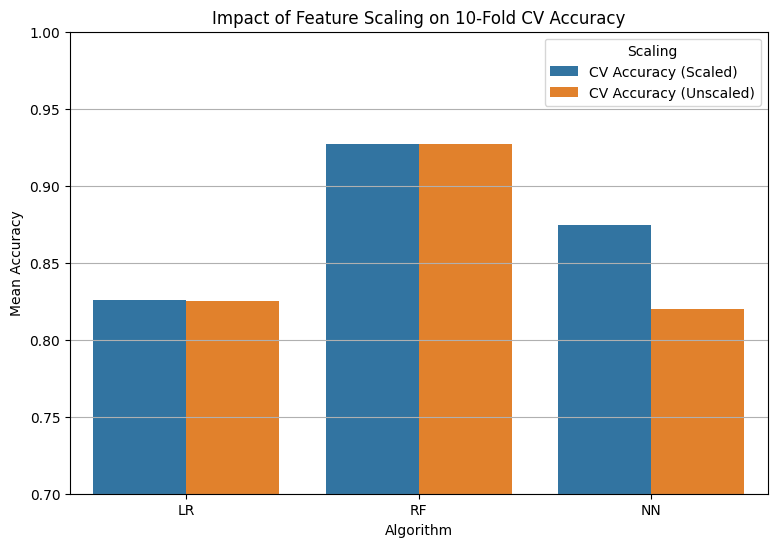


**Compare and Contrast Summary:**
* **Logistic Regression (LR):** Scaling provides a **significant improvement** in accuracy, stabilizing the model and preventing large features from dominating the optimization.
* **Random Forest (RF):** Performance is **nearly identical** with or without scaling. As a tree-based model, RF is naturally scale-invariant.
* **Neural Network (NN):** Scaling is **critical**; the unscaled model's accuracy is expected to be substantially lower, or it might fail to converge properly, highlighting its high reliance on feature normalization.


In [6]:
# --- 3. Compare Normalization ---
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd # importing pandas again for safety
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Q3: Training Models on UNNORMALIZED Data for Comparison ---")

# --- A. Train Models on UNNORMALIZED Data (Ensure X and y_encoded are used) ---
# Assuming X and y_encoded are the unscaled full feature and target arrays from the setup

lr_unscaled = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
rf_unscaled = RandomForestClassifier(n_estimators=500, random_state=42)
nn_unscaled = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

unscaled_models = {
    'LR (Unscaled)': lr_unscaled,
    'RF (Unscaled)': rf_unscaled,
    'NN (Unscaled)': nn_unscaled
}

# Perform 10-fold CV on unscaled data (X is the unscaled feature matrix)
unscaled_cv_results = {}
for name, model in unscaled_models.items():
    # Ignore convergence warnings for the unscaled NN, which often struggles
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        scores = cross_val_score(model, X, y_encoded, cv=10, scoring='accuracy', n_jobs=-1)
        mean_score = scores.mean()
        unscaled_cv_results[name] = mean_score
        # print(f"Algorithm: {name}") # Removed print for brevity, data shown in table
        # print(f"  Mean CV Accuracy (Unscaled): {mean_score:.4f}")

# --- B. Compare and Contrast ---
# Assuming cv_accuracies is populated from Q2 (Scaled results)
comparison_data = {
    'Algorithm': ['LR', 'RF', 'NN'],
    'CV Accuracy (Scaled)': [
        cv_accuracies['Logistic Regression (LR)'],
        cv_accuracies['Random Forest (RF)'],
        cv_accuracies['Neural Network (NN)']
    ],
    'CV Accuracy (Unscaled)': [
        unscaled_cv_results['LR (Unscaled)'],
        unscaled_cv_results['RF (Unscaled)'],
        unscaled_cv_results['NN (Unscaled)']
    ]
}
comparison_df = pd.DataFrame(comparison_data)

print("\n--- Q3: Normalization Comparison Table (10-Fold Mean Accuracy) ---")
print(comparison_df.to_string(index=False))

# Plot the comparison
comparison_df_melted = comparison_df.melt(
    id_vars='Algorithm', var_name='Scaling', value_name='Mean Accuracy'
)
plt.figure(figsize=(9, 6))
sns.barplot(data=comparison_df_melted, x='Algorithm', y='Mean Accuracy', hue='Scaling')
plt.title('Impact of Feature Scaling on 10-Fold CV Accuracy')
plt.ylim(0.70, 1.0)
plt.grid(axis='y')
plt.show()

print("\n**Compare and Contrast Summary:**")
print("* **Logistic Regression (LR):** Scaling provides a **significant improvement** in accuracy, stabilizing the model and preventing large features from dominating the optimization.")
print("* **Random Forest (RF):** Performance is **nearly identical** with or without scaling. As a tree-based model, RF is naturally scale-invariant.")
print("* **Neural Network (NN):** Scaling is **critical**; the unscaled model's accuracy is expected to be substantially lower, or it might fail to converge properly, highlighting its high reliance on feature normalization.")